In [2]:
import pandas as pd 
import numpy as np
import os 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import scipy.stats as sp_stats

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [3]:
plasma_AC_df = pd.read_csv("{0}/plasma_AC.csv".format(csv_dir),header=3)
tissue_amine_df = pd.read_csv("{0}/tissue_amine.csv".format(csv_dir),header=3)
tissue_AC_df = pd.read_csv("{0}/tissue_AC.csv".format(csv_dir),header=3)

tissue_amine_df.dropna(how="all",inplace=True)
tissue_amine_df.dropna(how="all",axis=1,inplace=True)
plasma_AC_df.dropna(how="all",inplace=True)

tissue_amine_df.rename(columns=lambda x: x.strip(),inplace=True)
tissue_AC_df.rename(columns=lambda x: x.strip(),inplace=True)
plasma_AC_df.rename(columns=lambda x: x.strip(),inplace=True)


#AC and amine columns 
amine_columns = tissue_amine_df.columns[4:]
AC_columns = tissue_AC_df.columns[4:]
plasma_AC_columns = plasma_AC_df.columns[7:]

#Convert to nM for consistency with HWDC original experiment data 
tissue_AC_df.loc[:,AC_columns] = tissue_AC_df.loc[:,AC_columns]*1000
tissue_amine_df.loc[:,amine_columns] = tissue_amine_df.loc[:,amine_columns]
plasma_AC_df.loc[:,plasma_AC_columns] = plasma_AC_df.loc[:,plasma_AC_columns]*1000

show_tables = False
if show_tables:
    with pd.option_context('display.max_rows',None):
        display(plasma_AC_df)
        display(tissue_amine_df)
        display(tissue_AC_df)
        
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")
SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()    
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]    

In [4]:
import scipy as sp
# import learn as sklearn
from sklearn.cluster import KMeans

def sort_cluster_labels(labels,centers):
    if len(centers) == 2:
        unique_sorted_labels = list(set(labels))
        unique_sorted_labels.sort()
#         original_centers_mapping = dict(zip(unique_sorted_labels,centers))
        #Determine if clusters[0] has more features > clusters[1]; if so, reverse labels and return
        if sum(centers[0]>centers[1]) > len(centers[0])/2:  
            #Inversion of cluster order 
            invert_dict = {unique_sorted_labels[0]:unique_sorted_labels[1],
                          unique_sorted_labels[1]:unique_sorted_labels[0]}
            labels_srs = pd.Series(labels)
            inv_labels = labels_srs.map(invert_dict).values
            return inv_labels
        else: 
            return labels

    #TODO: generalizable case with 3+ clusters and multiple comparisons
    #     print(np.sum(centers,axis=1))

def kmeans_cluster_ms(ms_df,analytes,tissues,force_separate_arms=True,nan_handling="drop_samples",
                     offset=True):
    sample_ids = ms_df["SampleID"].unique().tolist()
    sample_arm = [re.match(r'MG\d+_([AB])[MF]\d+',sample_id).groups()[0] for sample_id in sample_ids]
    obs_df = pd.DataFrame(index=sample_ids)
    obs_df.loc[:,"Arm"] = sample_arm
    for tissue in tissues: 
        tissue_df = ms_df.loc[ms_df["Tissue"]==tissue]
        for analyte in analytes: 
            tissue_analyte_data = tissue_df[analyte]
            col_key = "{0}_{1}".format(tissue,analyte)
            obs_df.loc[tissue_df["SampleID"],col_key] = tissue_analyte_data.tolist()
    
    analyte_cols = obs_df.columns[1:].tolist()
    if nan_handling == "drop_samples" and obs_df.isna().values.any():
        obs_df = obs_df.dropna(axis=0,how="any")
    if force_separate_arms:
        #Cluster A observations
        obs_A_df = obs_df.loc[obs_df["Arm"]=="A"].drop("Arm",axis=1) #A data, numeric analyte data only
        whitened_A = sp.cluster.vq.whiten(obs_A_df)
        A_km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_A)
        A_cluster_labels,A_cluster_centers = A_km_results.labels_, A_km_results.cluster_centers_
        A_cluster_labels = sort_cluster_labels(A_cluster_labels,A_cluster_centers)
        
        #Cluster B observations
        obs_B_df = obs_df.loc[obs_df["Arm"]=="B"].drop("Arm",axis=1) #B data, numeric analyte data only
        whitened_B = sp.cluster.vq.whiten(obs_B_df)
        B_km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_B)
        B_cluster_labels, B_cluster_centers = B_km_results.labels_, B_km_results.cluster_centers_
        B_cluster_labels = sort_cluster_labels(B_cluster_labels,B_cluster_centers)
        #TODO: QC to make sure higher centroid has higher mean cluster label
        #Offset B cluster labels, add both to obs_df 
        if offset:
            B_cluster_labels = B_cluster_labels + len(set(A_cluster_labels))
        obs_df.loc[obs_A_df.index,"Cluster"] = A_cluster_labels
        obs_df.loc[obs_B_df.index,"Cluster"] = B_cluster_labels
    else:
        whitened_obs = sp.cluster.vq.whiten(obs_A_df.drop("Arm",axis=1))
        km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_obs)
        cluster_labels = km_results.labels_
        obs_df.loc[:,"Cluster"] = cluster_labels
    reordered_cols = ["Arm","Cluster"]
    reordered_cols.extend(analyte_cols)
    obs_df = obs_df[reordered_cols]
    obs_df.loc[:,"Cluster"] = obs_df.loc[:,"Cluster"].astype(int)
    return obs_df

soybean_4ACs = ["C16","C18","C18:1","C18:2"]
soybean_5ACs = ["C16","C18","C18:1","C18:2","C18:3"]

soybean_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_4ACs,tissues=["Gastroc","Quadriceps","Heart"])
soybean5_muscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps","Heart"])
SFA_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=SFA_ACs,tissues=["Gastroc","Quadriceps","Heart"])
UFA_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=UFA_ACs,tissues=["Gastroc","Quadriceps","Heart"])
soybean5_jej_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum"])
soybean4_jej_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_4ACs,tissues=["Jejunum"])

soybean5_skmuscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps"])
soybean_intestine_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum","Colon"])
# display(soybean_intestine_obs_df)

cluster_columns = ["Soybean4_allmuscle","Soybean5_allmuscle","Soybean5_skm","Soybean5_jej","Soybean4_jej","Soybean5_intestine"]
cluster_df = pd.DataFrame(index=soybean_obs_df.index,columns=cluster_columns)
cluster_df.loc[:,"Soybean4_allmuscle"] = soybean_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_allmuscle"] = soybean5_muscle_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_skm"] = soybean5_skmuscle_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_jej"] = soybean5_jej_obs_df["Cluster"]
cluster_df.loc[:,"Soybean4_jej"] = soybean4_jej_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_intestine"] = soybean_intestine_obs_df["Cluster"]
display(cluster_df[["Soybean5_skm","Soybean5_jej"]])


cluster_df.to_csv("analyte_cluster_labels.csv")

,Soybean5_skm,Soybean5_jej
MG01_AM1,0,0
MG01_AM2,0,1
MG01_AM3,0,0
MG01_AM4,1,1
MG01_AM5,0,0
MG01_AM6,0,0
MG01_AM7,0,1
MG01_AM8,1,0
MG01_AF1,0,0
MG01_AF2,0,0


In [5]:
HWDC_cluster_palette={0:"#FEACA7",1:"#FF2804",2:"#AAAAAA",3:"#000000"} 
HWDC_reds_cluster_palette = {0:"#FEACA7",1:"#FF2804"}
HWDC_blacks_cluster_palette = {2:"#AAAAAA",3:"#000000"}

figures_dir = "figures/analyte_scatter"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

soybean_SFA_ACs = ["C16","C18"]
soybean_UFA_ACs = ["C18:1","C18:2"]

soybean_4ACs = ["C16","C18","C18:1","C18:2"]
analyte_ax_map = {"C16":0,"C18":0,"C18:1":1,"C18:2":1}
analyte_ax_map_5AC = {"C16":0,"C18":0,"C18:1":1,"C18:2":1,"C18:3":1}

In [6]:
def analyte_long_df(ms_df,analytes,tissue1,tissue2,obs_df=pd.DataFrame(),axes_analyte_map=None,zscore=False):
    """
    Generate long form DataFrame of Mass Spec data for tissue1, tissue2 for analytes. 
    @param ms_df: 
    @param analytes: 
    @param tissue1:
    @param tissue2:
    @param obs_df: 
    @param axes_analyte_map: Dictionary mapping analyte strings to 
    @return long_df: Long form DataFrame with index and columns specified as below. 
    Index is mouseID_analyte for each analyte in analytes; columns are Tissue1 and Tissue2 analyte values, Analyte,
    and Analyte_Axes (populated from axes_analyte_map), which allows specific analytes to be grouped together for 
    axes scaling.  
    """
    tissue1_df = ms_df.loc[ms_df["Tissue"]==tissue1]
    tissue2_df = ms_df.loc[ms_df["Tissue"]==tissue2]
    if len(tissue1_df) != len(tissue2_df): #Missing samples case for one tissue 
        if len(tissue1_df) > len(tissue2_df):
            tissue1_df = tissue1_df.loc[tissue1_df["SampleID"].isin(tissue2_df["SampleID"])]
            obs_df = obs_df.loc[obs_df.index.isin(tissue2_df["SampleID"])]
        elif len(tissue2_df) > len(tissue1_df):
            tissue2_df = tissue2_df.loc[tissue2_df["SampleID"].isin(tissue1_df["SampleID"])]
            obs_df = obs_df.loc[obs_df.index.isin(tissue1_df["SampleID"])]
    sample_ids = tissue1_df["SampleID"]
    sample_arm = [re.match(r'MG\d+_([AB])[MF]\d+',sample_id).groups()[0] for sample_id in sample_ids]
    tissue1_analytes = tissue1_df.loc[:,analytes]
    tissue2_analytes = tissue2_df.loc[:,analytes]
    
    #Initialize long_df; include Cluster and Analyte_Arm columns if obs_df is provided 
    long_columns = [tissue1,tissue2,"Analyte","Arm","MouseID","Analyte_Axes"]
    obs_columns = ["Cluster","Analyte_Arm"]
    if len(obs_df)>0: 
        long_columns.extend(obs_columns)    
    long_df = pd.DataFrame(columns=long_columns)
    
    for analyte in analytes:
        analyte_index = pd.Index(["{0}_{1}".format(sampleid, analyte) for sampleid in sample_ids])
        analyte_long_df = pd.DataFrame(index=analyte_index,columns=long_columns)
        t1_analyte = tissue1_analytes[analyte]
        t2_analyte = tissue2_analytes[analyte]
        if zscore: 
            analyte_long_df.loc[analyte_index,tissue1] = sp_stats.zscore(t1_analyte.tolist())
            analyte_long_df.loc[analyte_index,tissue2] = sp_stats.zscore(t2_analyte.tolist())
        else:
            analyte_long_df.loc[analyte_index,tissue1] = t1_analyte.tolist()
            analyte_long_df.loc[analyte_index,tissue2] = t2_analyte.tolist()
        analyte_long_df.loc[analyte_index,"Analyte"] = [analyte]*len(analyte_long_df)
        analyte_long_df.loc[analyte_index,"Arm"] = sample_arm 
        analyte_long_df.loc[analyte_index,"MouseID"] = sample_ids.tolist()
        analyte_long_df.loc[analyte_index,"Analyte_Arm"] = ["{0}_{1}".format(analyte,arm) for arm in sample_arm]
        if len(obs_df)>0:
            analyte_long_df.loc[analyte_index,"Cluster"] = obs_df["Cluster"].tolist()
            
        if axes_analyte_map:
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = \
            analyte_long_df.loc[analyte_index,"Analyte"].map(axes_analyte_map).astype(int)
        else: 
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = [0] * len(analyte_index)
            
        long_df = pd.concat([long_df,analyte_long_df])
    return long_df

def single_tissue_analyte_long_df(ms_df,analytes,tissue1,obs_df=pd.DataFrame(),axes_analyte_map=None,zscore=False):
    tissue1_df = ms_df.loc[ms_df["Tissue"]==tissue1]
    #TODO: mismatch length checking for tissue1_df and obs_df 
    sample_ids = tissue1_df["SampleID"]
    sample_arm = [re.match(r'MG\d+_([AB])[MF]\d+',sample_id).groups()[0] for sample_id in sample_ids]
    tissue1_analytes = tissue1_df.loc[:,analytes]
    
    #Initialize long_df; include Cluster and Analyte_Arm columns if obs_df is provided 
    long_columns = [tissue1,"Analyte","Arm","MouseID","Analyte_Axes"]
    obs_columns = ["Cluster","Analyte_Arm"]
    if len(obs_df)>0: 
        long_columns.extend(obs_columns)    
    long_df = pd.DataFrame(columns=long_columns)
    
    for analyte in analytes:
        analyte_index = pd.Index(["{0}_{1}".format(sampleid, analyte) for sampleid in sample_ids])
        analyte_long_df = pd.DataFrame(index=analyte_index,columns=long_columns)
        t1_analyte = tissue1_analytes[analyte]
        if zscore: 
            analyte_long_df.loc[analyte_index,tissue1] = sp_stats.zscore(t1_analyte.tolist())
        else:
            analyte_long_df.loc[analyte_index,tissue1] = t1_analyte.tolist()
        analyte_long_df.loc[analyte_index,"Analyte"] = [analyte]*len(analyte_long_df)
        analyte_long_df.loc[analyte_index,"Arm"] = sample_arm 
        analyte_long_df.loc[analyte_index,"MouseID"] = sample_ids.tolist()
        analyte_long_df.loc[analyte_index,"Analyte_Arm"] = ["{0}_{1}".format(analyte,arm) for arm in sample_arm]
        if len(obs_df)>0:
            analyte_long_df.loc[analyte_index,"Cluster"] = obs_df["Cluster"].tolist()
            
        if axes_analyte_map:
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = \
            analyte_long_df.loc[analyte_index,"Analyte"].map(axes_analyte_map).astype(int)
        else: 
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = [0] * len(analyte_index)
            
        long_df = pd.concat([long_df,analyte_long_df])
    return long_df

In [7]:
def sync_parasite_axes(twin_ax1,twin_ax2, force_zero=True):
    """Helper function to synchronize axes limits for two parasite axes
    @param twin_ax1: twin axes 1 
    @param twin_ax2: twin axes 2 
    """
    #Get ax limits for twin_ax1 and twin_ax2 

    twin_xmin1, twin_xmax1 = twin_ax1.get_xlim()
    twin_ymin1, twin_ymax1 = twin_ax1.get_ylim()
    twin_xmin2, twin_xmax2 = twin_ax2.get_xlim()
    twin_ymin2, twin_ymax2 = twin_ax2.get_ylim()
    if twin_xmax1 > twin_xmax2: 
        set_xmin = twin_xmin1
        set_xmax = twin_xmax1
    else: 
        set_xmin = twin_xmin2
        set_xmax = twin_xmax2
    if twin_ymax1 > twin_ymax2: 
        set_ymin = twin_ymin1
        set_ymax = twin_ymax1
    else: 
        set_ymin = twin_ymin2
        set_ymax = twin_ymax2
    # Force axes min to 0 if force_zero
    if force_zero: 
        set_xmin, set_ymin = 0, 0
    #Sync lims 
    twin_ax1.set_xlim(set_xmin,set_xmax)
    twin_ax2.set_xlim(set_xmin,set_xmax)
    twin_ax1.set_ylim(set_ymin,set_ymax)
    twin_ax2.set_ylim(set_ymin,set_ymax)
    
def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title(title,weight="bold",fontsize=title_size)
    
def SCC_PCC_annotation(long_df,ax,tissue1,tissue2): 
    """Calculate Spearman and Pearson correlation coefficients, annotate them onto ax in upper left. 
    """
    #Calculate SCC, PCC; string formatting into text 
    scc_r, scc_p = sp.stats.spearmanr(a=long_df[[tissue1,tissue2]], axis=0, nan_policy='propagate', alternative='two-sided')
    pcc_r, pcc_p = sp.stats.pearsonr(x=long_df[tissue1],y=long_df[tissue2])
    scc_str, pcc_str = "Spearman R: {:.3f}".format(scc_r),"Pearson R: {:.3f}".format(pcc_r)
    #Text annotation onto ax 
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xdiff, ydiff = xmax-xmin, ymax-ymin
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.05,s=scc_str,fontsize=10)
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.1,s=pcc_str,fontsize=10)

def MS_cluster_scatter(data,tissue1,tissue2,ax,arm=None,hue_type="cluster",analyte_palette=None,legend_labels=[],
                       dual_axes=False,zscore=False):
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    if hue_type == "cluster": 
        sns.scatterplot(data=data,x=tissue1,y=tissue2,ax=ax,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.95)
        legend_title = "Cluster"
    elif hue_type == "cluster_mouse":
        #Analyte plotting split by mouse_ID
        high_cluster_label, low_cluster_label = max(data["Cluster"].unique()),min(data["Cluster"].unique())
        data_high,data_low = data.loc[data["Cluster"]==high_cluster_label],data.loc[data["Cluster"]==low_cluster_label]
        n_high, n_low = len(data_high["MouseID"].unique()),len(data_low["MouseID"].unique())
        if arm == "A":
            #Red based palettes for A animals
            high_palette = sns.color_palette("light:#D63F0E_r",n_colors=n_high+2)[:n_high] #drop last colors (too light/dark)
            low_palette = sns.color_palette("dark:#FA8BC0_r",n_colors=n_low+2)[:n_low]
        else: 
            #Blue based palettes for B animals 
            high_palette = sns.color_palette("light:#014F9E_r",n_colors=n_high+2)[:n_high] #drop last colors (too light/dark)
            low_palette = sns.color_palette("light:#0C9B9E_r",n_colors=n_low+2)[:n_low]
        sns.scatterplot(data=data_high,x=tissue1,y=tissue2,ax=ax,hue="MouseID",palette=high_palette,alpha=0.95)
        sns.scatterplot(data=data_low,x=tissue1,y=tissue2,ax=ax,hue="MouseID",palette=low_palette,alpha=0.95)
        legend_title = "MouseID"
    elif hue_type == "analyte":
        n_groups = len(data["Arm"].unique())
        if not analyte_palette:
            raise ValueError("Must provide analyte_palette if using hue_type='analyte'")
        elif len(analyte_palette) != n_groups:
            raise ValueError("Analyte palette is incorrect length and must provide one hue per group.'")
        sns.scatterplot(data=data,x=tissue1,y=tissue2,ax=ax,hue="Arm",palette=analyte_palette,alpha=0.8)
        legend_title = "Analyte"
    #x and ylabel handling 
    if zscore: 
        xlabel, ylabel = "{0} Z-Score".format(tissue1.title()),"{0} Z-Score".format(tissue2.title())
    else: 
        xlabel, ylabel = tissue1.title(), tissue2.title()
        
    ax.set_xlabel(xlabel,fontsize=14,fontweight="bold")
    ax.set_ylabel(ylabel,fontsize=14,fontweight="bold")
    #Legend handling 
    handles, labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        if hue_type == "analyte":
            n_legend_labels = len(legend_labels)
            labels = legend_labels
#             labels = labels[:-n_legend_labels]+legend_labels #replace last entries of labels with legend_labels
        else:
            labels = legend_labels
#             print("updated labels: {0}".format(labels))
    ax.legend(handles,labels,title=legend_title)
    if dual_axes:
        if hue_type == "cluster":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        elif hue_type == "cluster_mouse":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        elif hue_type == "analyte":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
        
def dual_axis_MS_scatter(data,tissue1,tissue2,ax,axes_analyte_map,
                         arm=None,hue_type="cluster",analytes_palette=[],legend_labels=[]):
    ax_twinx = ax.twinx()
    ax_twinxy = ax_twinx.twiny()
    for i,ax_idx in enumerate(set(axes_analyte_map.values())):
        ax_data = data.loc[data["Analyte_Axes"] == ax_idx,:]
        analytes_str = ", ".join(ax_data["Analyte"].unique())
        if i == 0: 
            plot_ax, xlabel_ax, ylabel_ax = ax,ax,ax
        else:
            plot_ax, xlabel_ax, ylabel_ax = ax_twinxy,ax_twinxy,ax_twinx
        #analyte_palette 
        if hue_type == "cluster" or hue_type == "cluster_mouse":
            MS_cluster_scatter(ax_data,tissue1,tissue2,plot_ax,arm=arm,hue_type=hue_type,
                                legend_labels=legend_labels,dual_axes=True)
        elif hue_type == "analyte":
            if len(analytes_palette) > 0: 
                analyte_palette = analytes_palette[2*i:2*i+2]
                legend_sublabels = legend_labels[2*i:2*i+2]
            else: 
                analyte_palette = None
                legend_sublabels = legend_labels
            MS_cluster_scatter(ax_data,tissue1,tissue2,plot_ax,arm=arm,hue_type=hue_type,
                              analyte_palette=analyte_palette,legend_labels=legend_sublabels,dual_axes=True)
            plot_ax_handles, plot_ax_labels = plot_ax.get_legend_handles_labels()
            ax_handles, ax_labels = ax.get_legend_handles_labels()
            if plot_ax_handles[0] not in ax_handles: 
                combined_handles = ax_handles + plot_ax_handles
                ax.legend(combined_handles,legend_labels)
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        
        #xlabel and ylabel handling for dual axes plots (ie correct assignment of labels for parasite axes)
        force_axis_labels = True
        if force_axis_labels:
            xlabel_ax.set_xlabel("{0} ({1})".format(tissue1,analytes_str),fontsize=12,fontweight="bold")
            ylabel_ax.set_ylabel("{0} ({1})".format(tissue2,analytes_str),fontsize=12,fontweight="bold")
            labels = ylabel_ax.get_yticklabels()
            [label.set_fontweight('bold') for label in labels]
    if ax_twinxy.get_legend():
        ax_twinxy.get_legend().remove()
    return ax, ax_twinxy
    
def arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type="cluster",axes_analyte_map={},zscore=False,
                            ax1_legend_labels=[],ax2_legend_labels=[]):
    """Wrapper function which plots data from Arm A and Arm B onto ax1 and ax2 respectively. 
    """
    #Generate twin axes if not plotting z_scores and using axes_analyte_map
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"] #Separate by arm 
    if not zscore and len(set(axes_analyte_map.values()))>1:
        ax1,ax1_twinxy = dual_axis_MS_scatter(long_df_A,tissue1,tissue2,ax1,hue_type=hue_type,arm="A",
                                             axes_analyte_map=axes_analyte_map,legend_labels=ax1_legend_labels)#legend_labels=...,analyte_palette=...?)
        ax2,ax2_twinxy = dual_axis_MS_scatter(long_df_B,tissue1,tissue2,ax2,hue_type=hue_type,arm="B",
                                             axes_analyte_map=axes_analyte_map,legend_labels=ax2_legend_labels)
        sync_parasite_axes(ax1_twinxy,ax2_twinxy,force_zero=not(zscore))
    else: 
        MS_cluster_scatter(long_df_A,tissue1,tissue2,ax1,arm="A",hue_type=hue_type,legend_labels=ax1_legend_labels,
                          zscore=zscore)
        MS_cluster_scatter(long_df_B,tissue1,tissue2,ax2,arm="B",hue_type=hue_type,legend_labels=ax2_legend_labels,
                          zscore=zscore)
        analytes_str = ", ".join(analytes)
        if zscore: 
            xlabel = "{0} Analyte Z-Score".format(tissue1,analytes_str)
            ylabel = "{0} Analyte Z-Score".format(tissue2,analytes_str)
        else: 
            xlabel = "{0} ({1})".format(tissue1,analytes_str)
            ylabel = "{0} ({1})".format(tissue2,analytes_str)
        for ax in [ax1,ax2]:
            ax.set_xlabel(xlabel,fontweight="bold")
            ax.set_ylabel(ylabel,fontweight="bold")
        
    
    
def SCC_plot_arms_clusters(ms_df,analytes,obs_df,tissue1="Gastroc",tissue2="Quadriceps",title_analytes_label="",
                           title_clusters_label="soybean ACs",
                         ax=None,hue_type="cluster",axes_analyte_map=None,zscore=False):
    """
    """
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2,
                              obs_df=obs_df,axes_analyte_map=axes_analyte_map,zscore=zscore)
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"] #Separate by arm 
#     display(long_df)
    #Cluster - two subplots, one per arm; overlay different axes according to axes_analyte_map
    if hue_type == "cluster" or hue_type == "cluster_mouse":
        if not ax: 
            if hue_type == "cluster":
                fig,axes = plt.subplots(2,1,figsize=(7,13),sharex=True,sharey=True)
                fig.tight_layout(pad=8)
                ax1,ax2 = axes
            elif hue_type == "cluster_mouse":
                fig,axes = plt.subplots(2,2,figsize=(18,18),sharex=True,sharey=True)
                if not zscore:
                    fig.tight_layout(pad=16)
                else: 
                    fig.tight_layout(pad=12)
                ax1,ax2 = axes[0,0],axes[1,0]
        A_cluster_labels = ["Prevotella Low\nAC Cluster", "Prevotella High\nAC Cluster"]
        B_cluster_labels = ["Non-Prevotella\nLow AC Cluster", "Non-Prevotella\nHigh AC Cluster"]
        arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type="cluster",
                                     axes_analyte_map=axes_analyte_map,zscore=zscore,
                                ax1_legend_labels=A_cluster_labels,ax2_legend_labels=B_cluster_labels)
        
        #Title and legend handling for both arms
        title_str = "{0} vs {1} for {2},\nPrevotella animals clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
        ax1.set_title(title_str,fontsize=14,fontweight="bold") 
        title_str = "{0} vs {1} for {2},\nNon-Prevotella animals clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
        ax2.set_title(title_str,fontsize=14,fontweight="bold")
        #SCC and PCC annotation
        for ax,long_df_arm in zip([ax1,ax2],[long_df_A,long_df_B]):
            SCC_PCC_annotation(long_df_arm,ax,tissue1,tissue2)
        ### moving onto right axes - by mouse###
            
        if hue_type == "cluster_mouse": #Fill in remaining two plots with hue by mice 
            #Axes specifying in 2x2 subplots set up 
            ax1,ax2 = axes[0,1],axes[1,1]
            arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type=hue_type,
                                     axes_analyte_map=axes_analyte_map,zscore=zscore)
            #Title str formatting 
            title_str = "{0} vs {1} for {2},\nPrevotella animals, colored by mouse".format(tissue1,tissue2,title_analytes_label)
            ax1.set_title(title_str,fontsize=14,fontweight="bold") 
            title_str = "{0} vs {1} for {2},\nNon-Prevotella animals, colored by mouse".format(tissue1,tissue2,title_analytes_label)
            ax2.set_title(title_str,fontsize=14,fontweight="bold")
            #SCC and PCC annotation
            for ax,long_df_arm in zip([ax1,ax2],[long_df_A,long_df_B]):
                SCC_PCC_annotation(long_df_arm,ax,tissue1,tissue2)    
    return fig 

def SCC_plot_clusters_analytes(ms_df,analytes,obs_df,tissue1="Gastroc",tissue2="Quadriceps",title_analytes_label="",
                         ax=None,hue_type="cluster",axes_analyte_map={},zscore=False,
                               title_clusters_label="soybean ACs",raw_single_ax=True):
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2,
                              obs_df=obs_df,axes_analyte_map=axes_analyte_map,zscore=zscore)
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"]
    #Determine dual_axes 
    if not zscore and not raw_single_ax and len(set(axes_analyte_map.values()))>1:
        dual_axes = True
    else:
        dual_axes = False 
    
    if hue_type == "cluster_analyte":
        #Fig, ax initialization 
        if not ax: 
            if dual_axes: 
                fig,axes = plt.subplots(1,2,figsize=(16,9),sharex=True,sharey=True)
                fig.tight_layout(pad=16)
                ax1,ax2 = axes
            else: 
                fig,axes = plt.subplots(1,2,figsize=(13,7),sharex=True,sharey=True)
                fig.tight_layout(pad=12)
                ax1,ax2 = axes
        #MS_cluster call ax1 - arm clusters, superimposed Arm A and B on same axes
        new_cluster_labels = ["Prevotella Low\nAC Cluster", "Prevotella High\nAC Cluster",
                             "Non-Prevotella\nLow AC Cluster", "Non-Prevotella\nHigh AC Cluster"]
        if dual_axes: 
            dual_axis_MS_scatter(long_df,tissue1,tissue2,ax1,axes_analyte_map,
                                 hue_type="cluster",legend_labels=new_cluster_labels)
        else: 
            MS_cluster_scatter(long_df,tissue1,tissue2,ax=ax1,arm=None,hue_type="cluster",analyte_palette=None,
                          legend_labels=new_cluster_labels,zscore=zscore)
        SCC_PCC_annotation(long_df,ax1,tissue1,tissue2)
        #Ax2 - analytes 
        n_analyte_classes = len(long_df["Analyte_Axes"].unique())
        analytes_palette = sns.color_palette("Paired")[:n_analyte_classes*2][::-1]
        new_analyte_labels = ["Prevotella SFA\nSoybean ACs", "Non-Prevotella SFA\nSoybean ACs",
                             "Prevotella UFA\nSoybean ACs", "Non-Prevotella SFA\nSoybean ACs"]
        if dual_axes:
            ax2, ax2_twinxy = dual_axis_MS_scatter(long_df,tissue1,tissue2,ax2,axes_analyte_map,
                                 hue_type="analyte",analytes_palette=analytes_palette,legend_labels=new_analyte_labels)
        else: 
            for i in range(n_analyte_classes):
                sub_palette = analytes_palette[2*i:2*i+2]
    #             analyte_legend_labels = new_analyte_labels[2*i:2*i+2]
                analytes_data = long_df.loc[long_df["Analyte_Axes"]==i]
                MS_cluster_scatter(analytes_data,tissue1,tissue2,ax=ax2,hue_type="analyte",analyte_palette=sub_palette,
                              zscore=zscore)
        #Handle legend labels and position outside of MS_cluster scatter since messy with multiuple calls on same ax
            handles, labels_ = ax2.get_legend_handles_labels()
            ax2.legend(handles,new_analyte_labels,title="Analyte")
            sns.move_legend(ax2, "upper left", bbox_to_anchor=(1,1))
            SCC_PCC_annotation(long_df,ax2,tissue1,tissue2)
        #Plot Titles
        if zscore:
            title_str1 = "{0} vs {1}\nAnalyte Z-Scores for {2},\nAll samples, clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
            title_str2 = "{0} vs {1}\nAnalyte Z-Scores for {2},\nAll samples, by analyte and arm".format(tissue1,tissue2,title_analytes_label)
        else:
            title_str1 = "{0} vs {1} for {2},\nAll samples clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
            title_str2 = "{0} vs {1} for {2},\nAll samples, by analyte and arm".format(tissue1,tissue2,title_analytes_label)
        ax1.set_title(title_str1,fontsize=14,fontweight="bold")
        ax2.set_title(title_str2,fontsize=14,fontweight="bold")
            
        #MS cluster call ax2 - hue_type = "analyte"

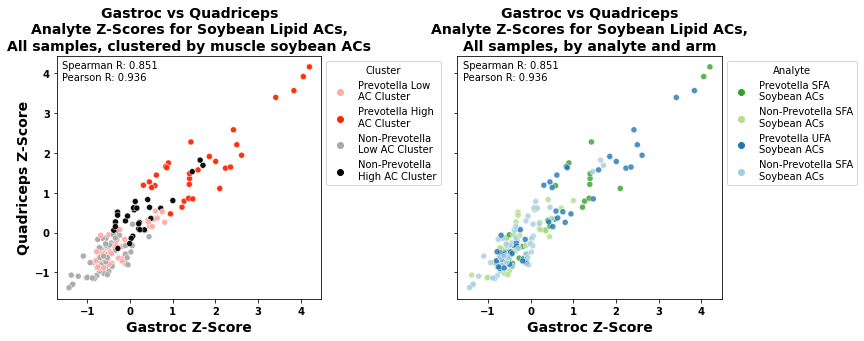

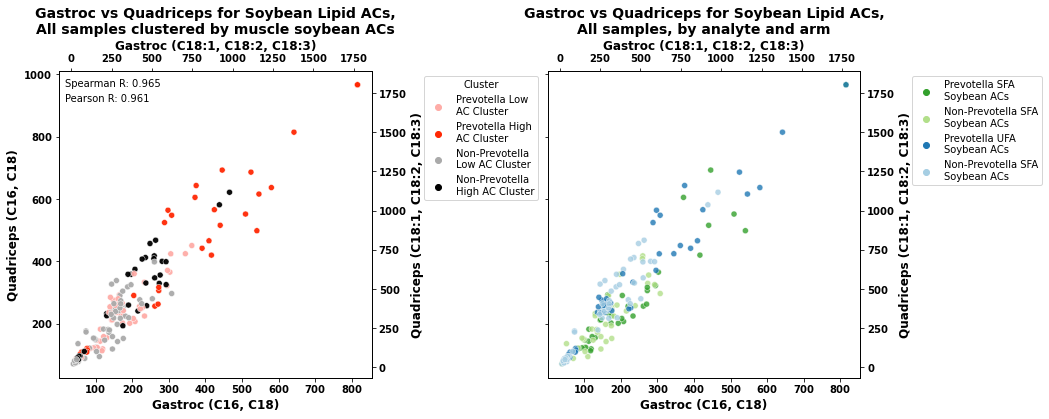

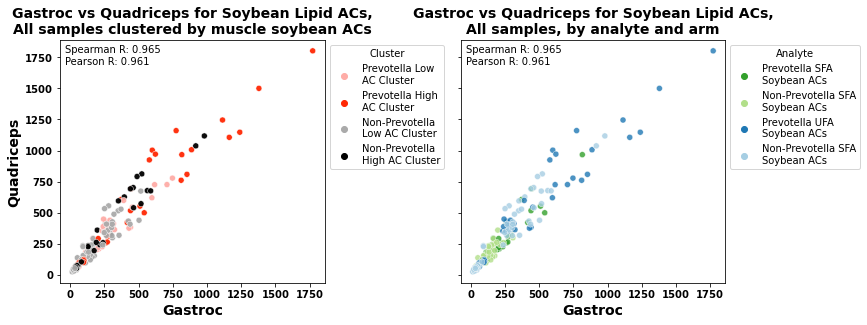

In [8]:
overwrite = True 
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

zscore_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_zscore.png".format(clusters_path,tissue_tag)
if not os.path.exists(zscore_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig(zscore_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
raw_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_raw.png".format(clusters_path,tissue_tag) #Dual ax raw
if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=False,title_clusters_label="muscle soybean ACs",
                                    raw_single_ax=False) #no zscore version 
    plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
raw_analyte_2panel_fpath = "{0}/soybean5AC_{1}2panel_raw_oneax.png".format(clusters_path,tissue_tag)
if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=False,title_clusters_label="muscle soybean ACs") #no zscore version 
    plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")


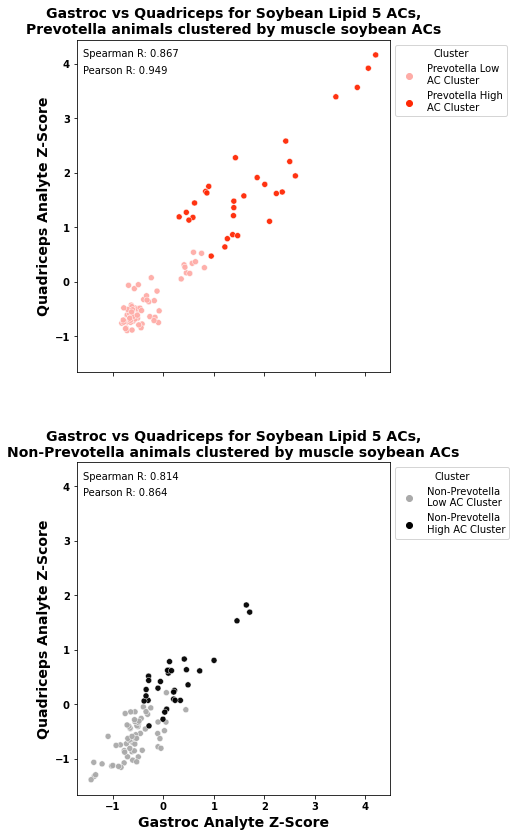

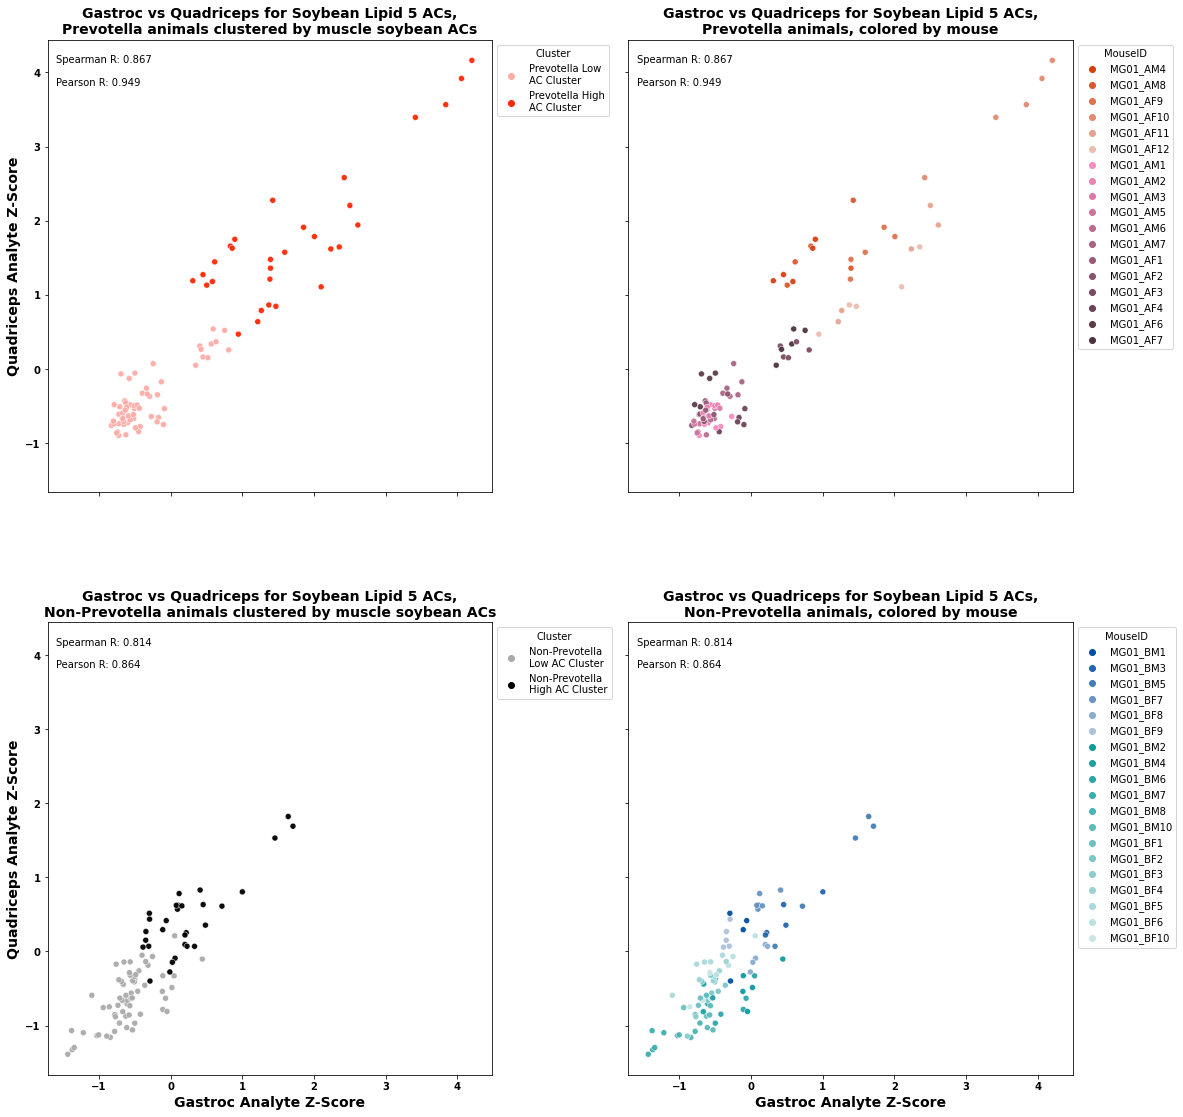

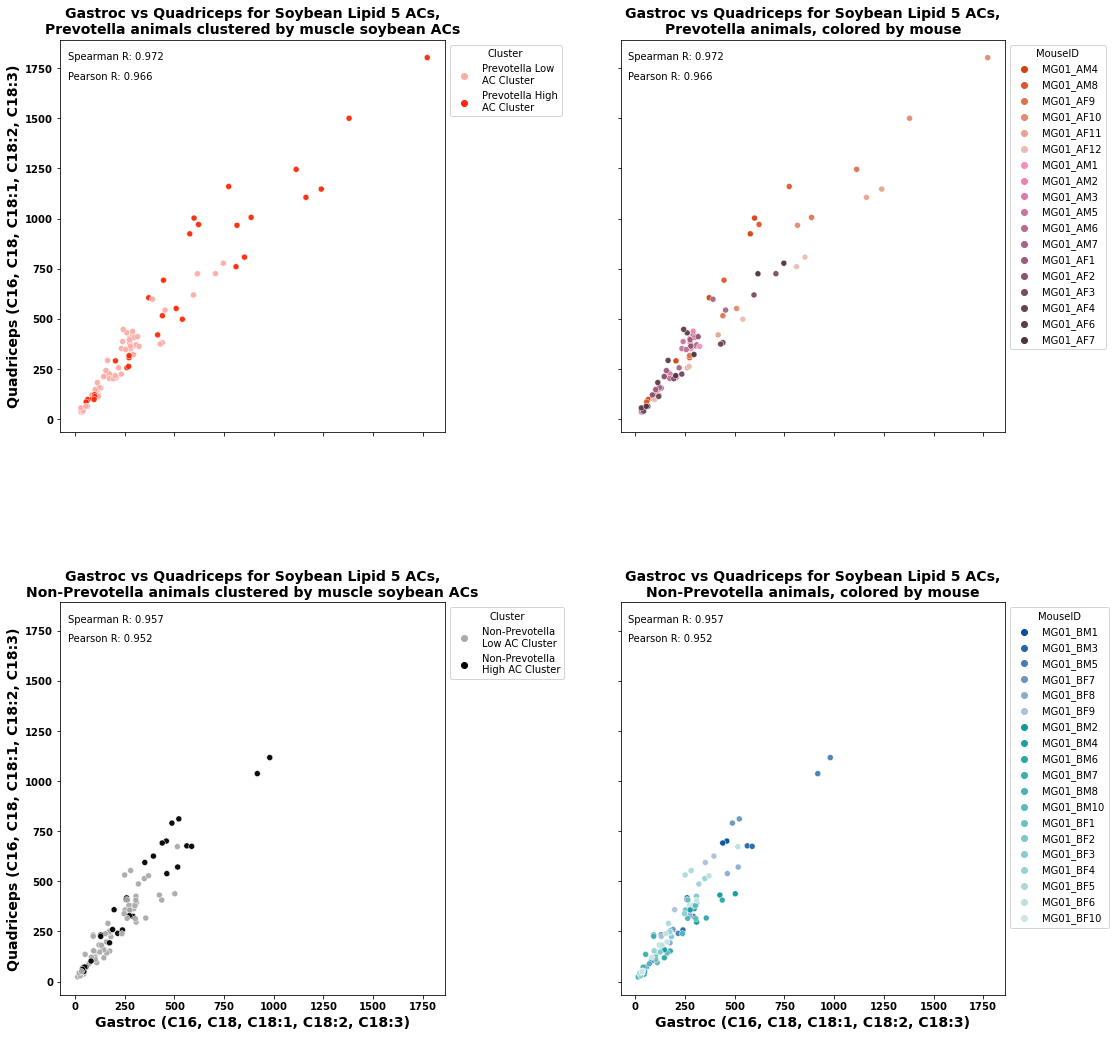

In [9]:
analyte_ax_map = {"C16":0,"C18":0,"C18:1":1,"C18:2":1}
analyte_ax_map_5AC = {"C16":0,"C18":0,"C18:1":1,"C18:2":1,"C18:3":1}
analyte_ax_map_5AC_single_ax = {"C16":0,"C18":0,"C18:1":0,"C18:2":0,"C18:3":0}
#Gastroc Quadriceps plots 
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

overwrite = True
if not os.path.exists("{0}/soybean5AC_clusters_2panel.png".format(clusters_path)) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                     tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_raw_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                     tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_ax_map_5AC_single_ax,zscore=False,title_clusters_label="muscle soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
    

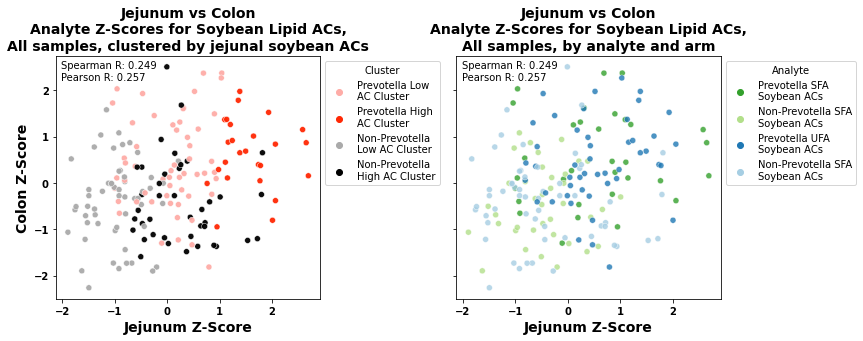

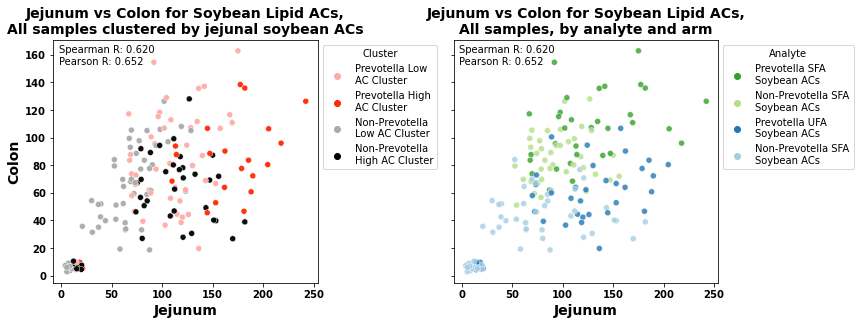

In [10]:
overwrite = True 
tissue_tag = "JC_jejunumclusters"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean5_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC


zscore_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_zscore.png".format(clusters_path,tissue_tag)
if not os.path.exists(zscore_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="jejunal soybean ACs")
    plt.savefig(zscore_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
raw_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_raw.png".format(clusters_path,tissue_tag)
if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=False,title_clusters_label="jejunal soybean ACs",
                                    raw_single_ax=True)
    plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

    


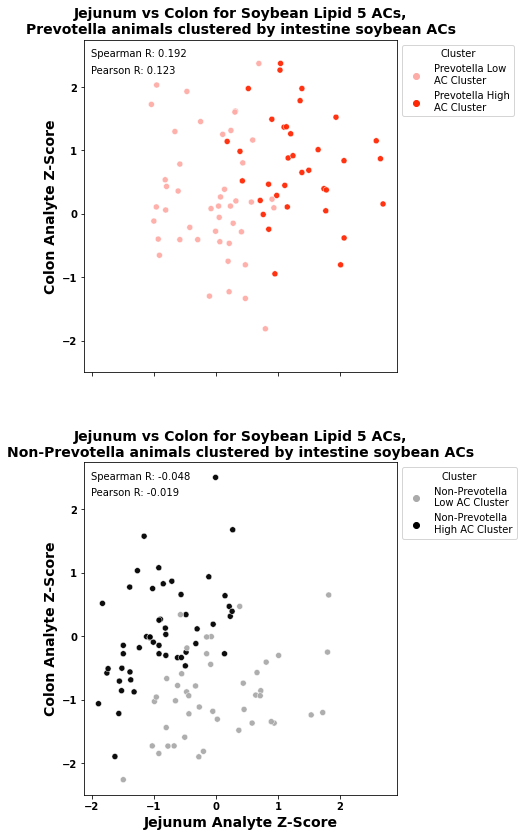

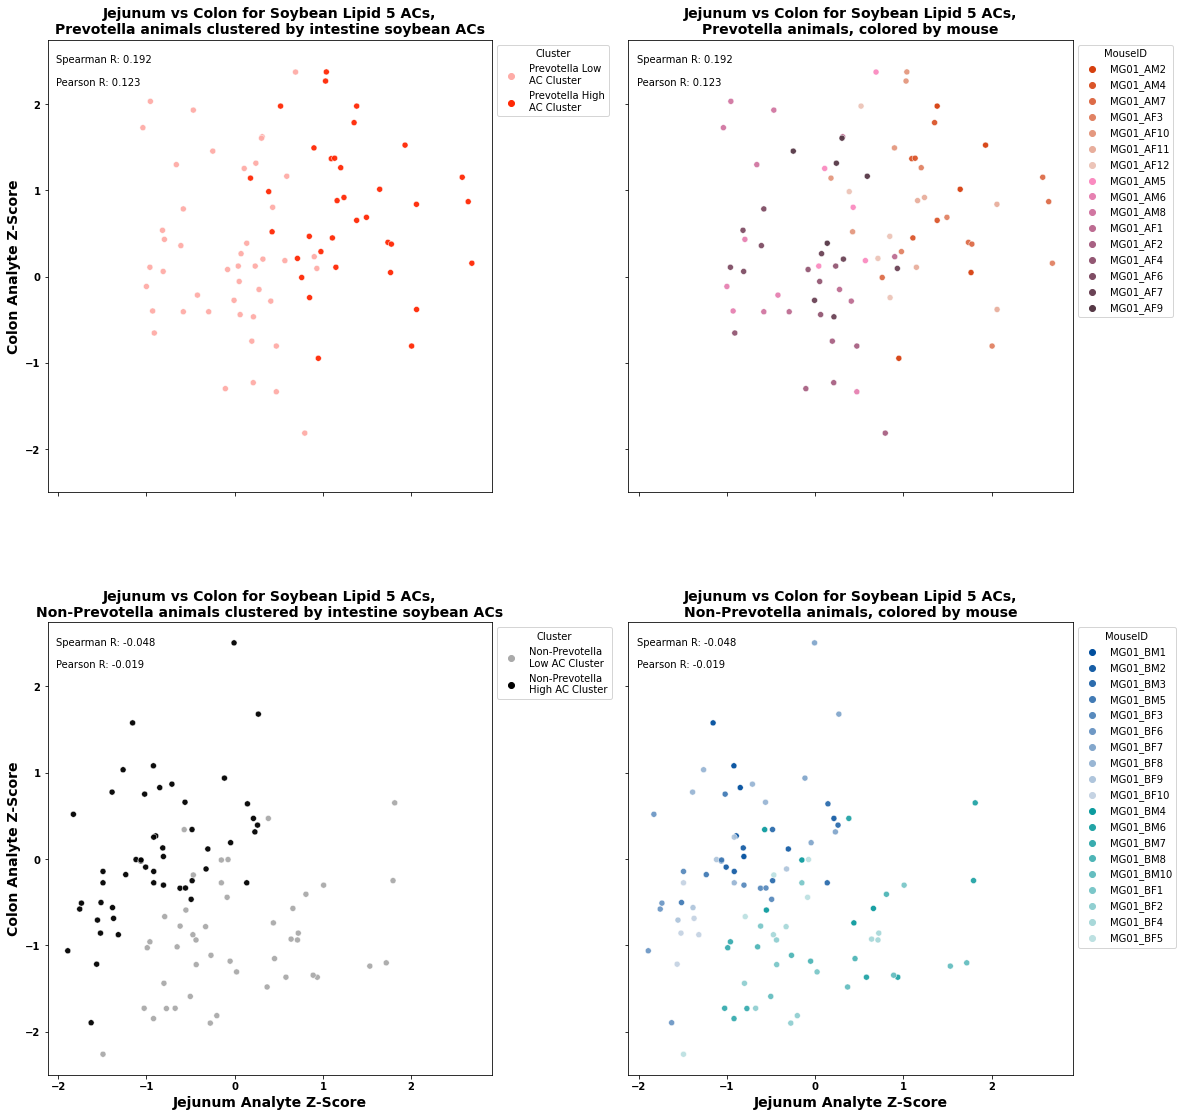

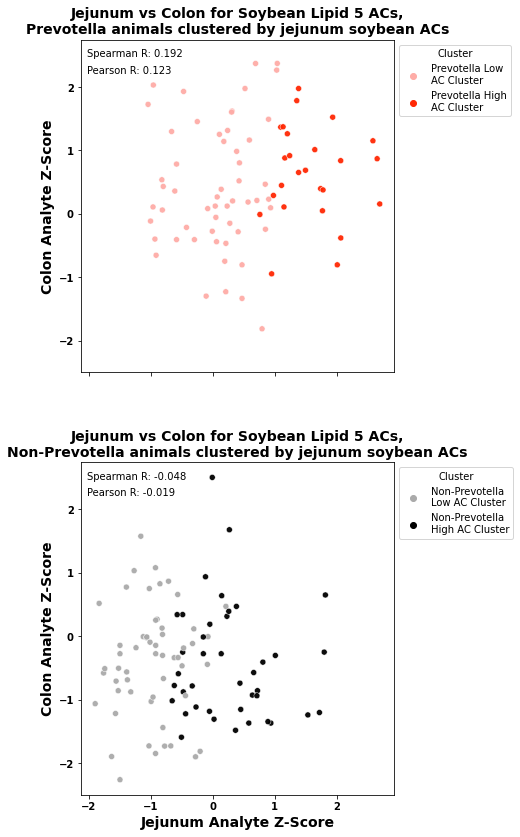

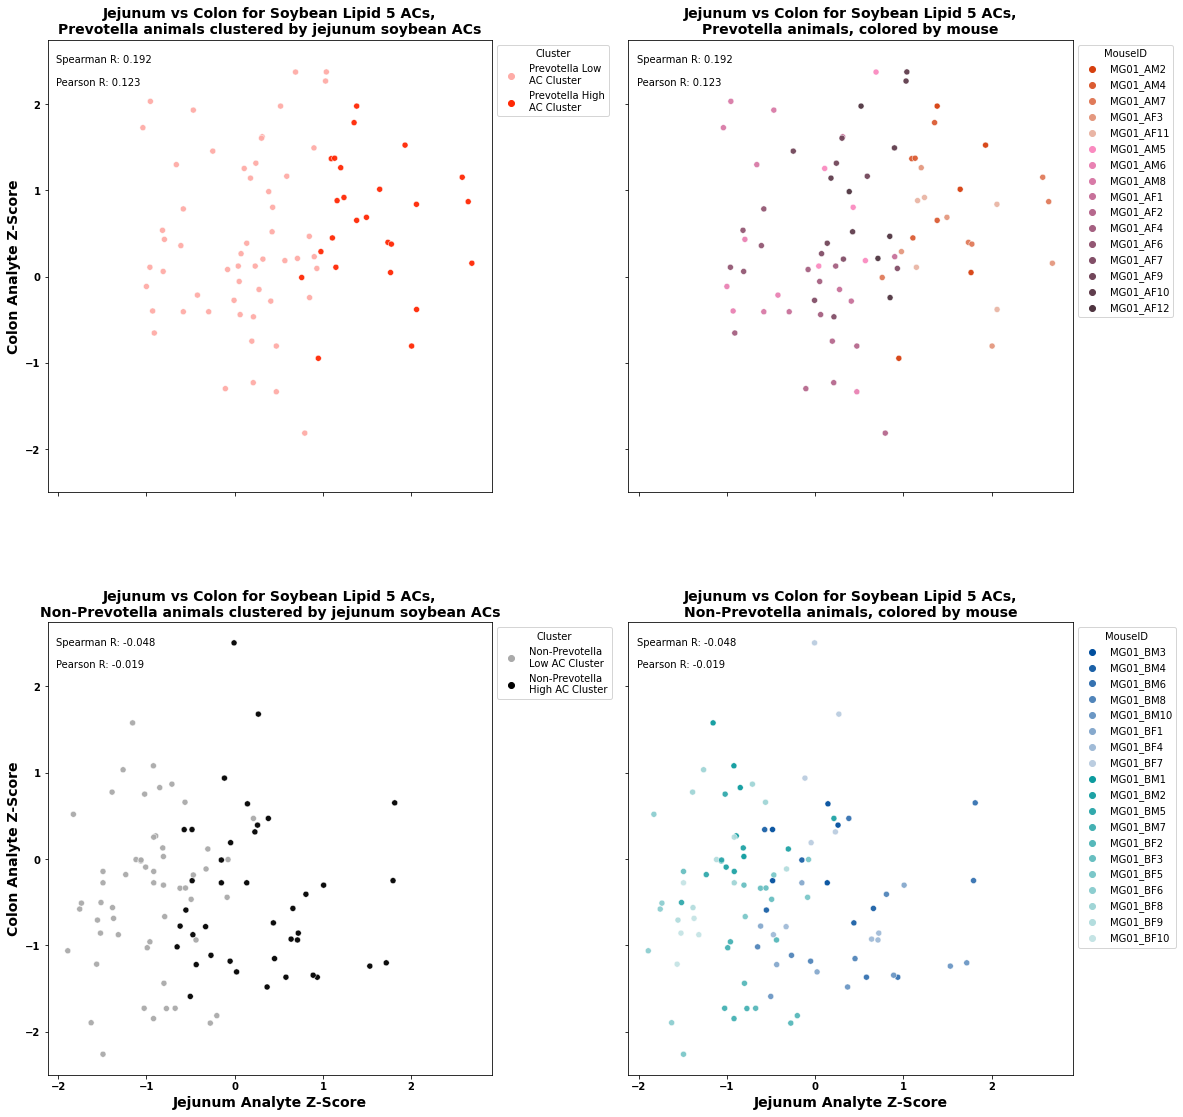

In [11]:
tissue_tag = "JC"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean_intestine_obs_df
analyte_axes_map = analyte_ax_map_5AC     
    
    
overwrite = True
arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel.png".format(clusters_path)
if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="intestine soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="intestine soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
#
tissue_tag = "JC_jejunumclusters"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean5_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC     
    
    
overwrite = True
arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel.png".format(clusters_path)
if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")


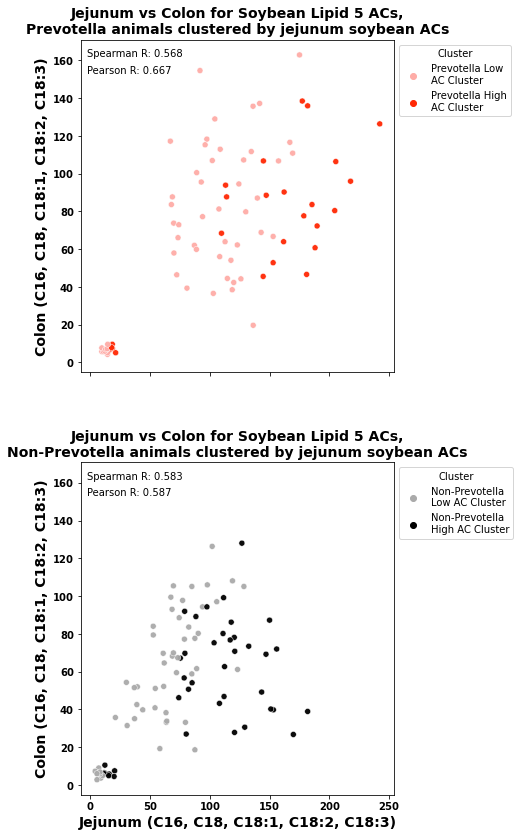

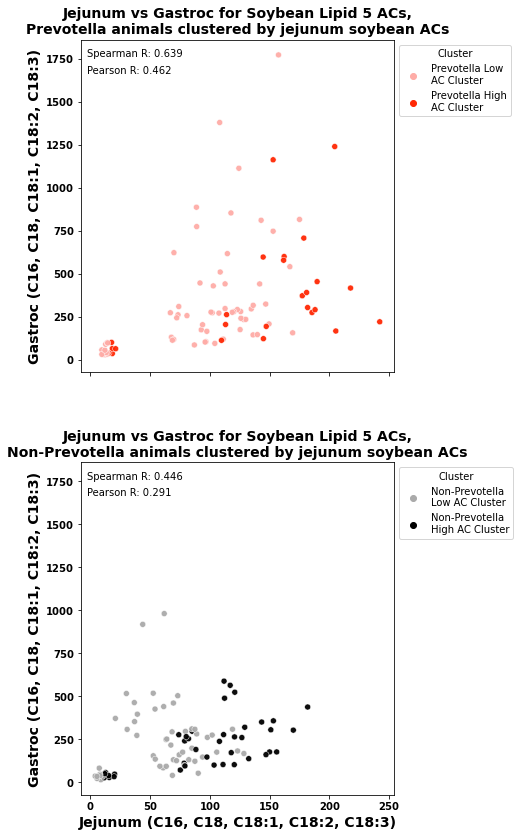

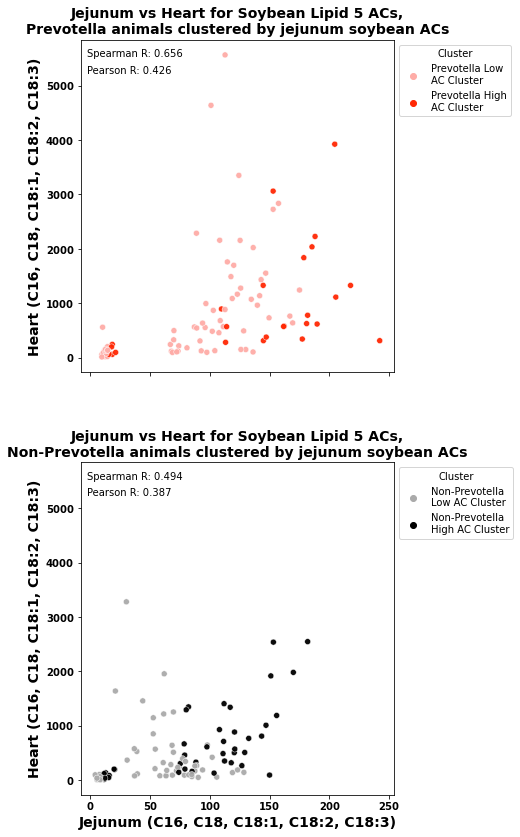

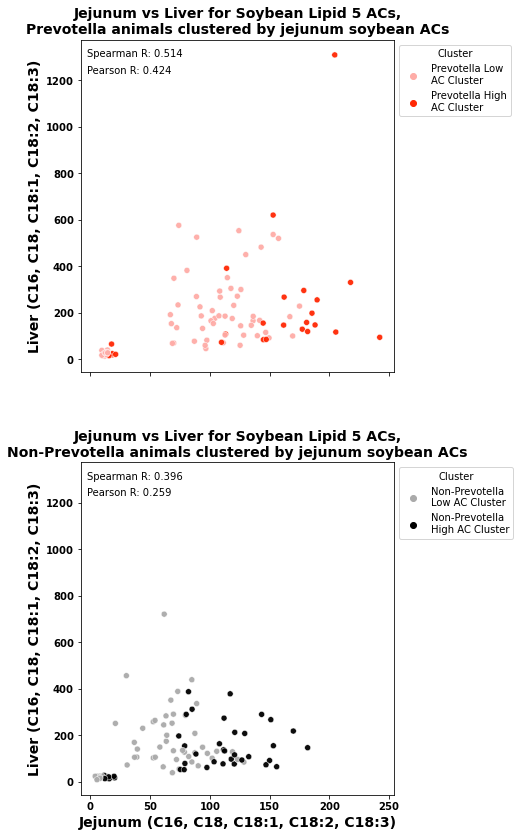

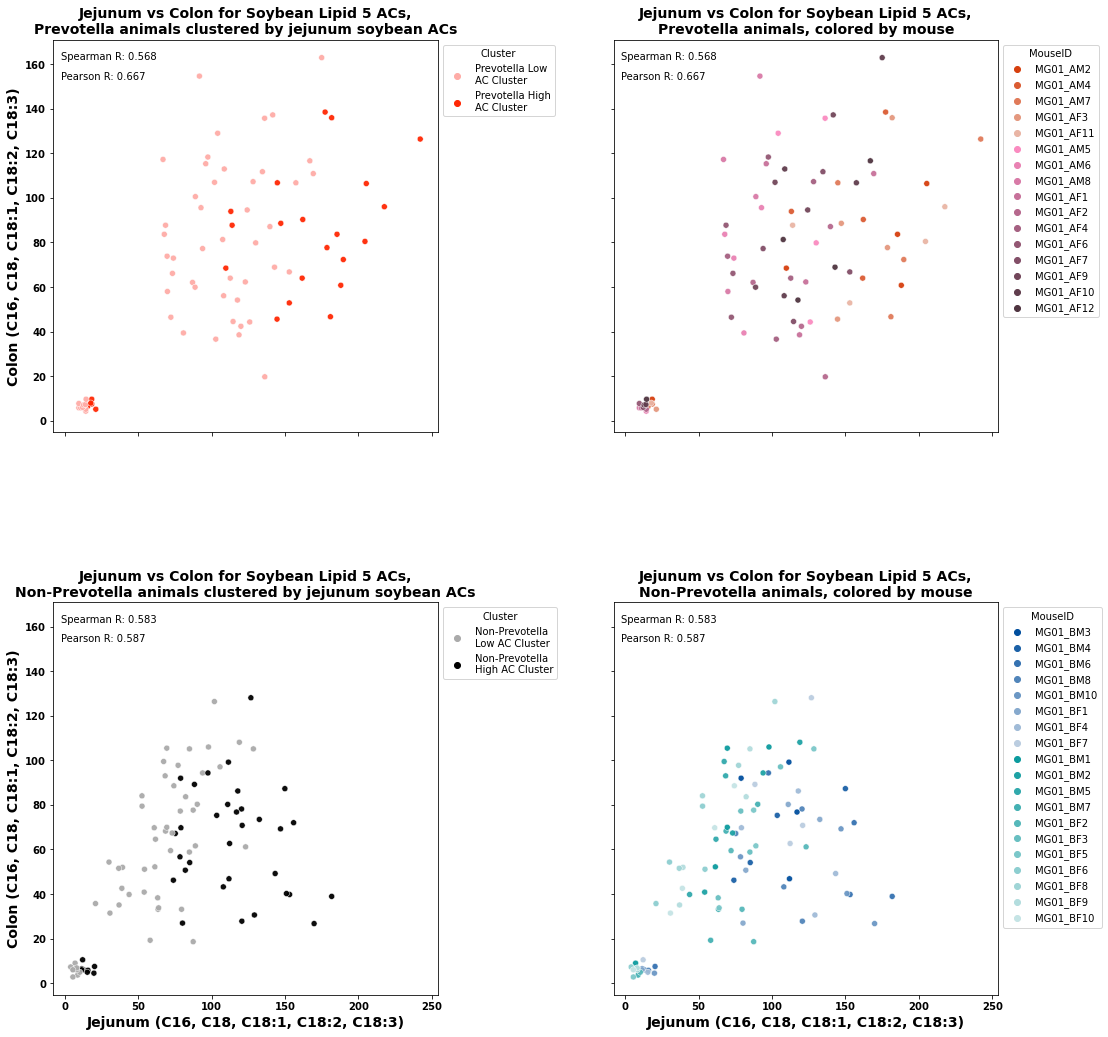

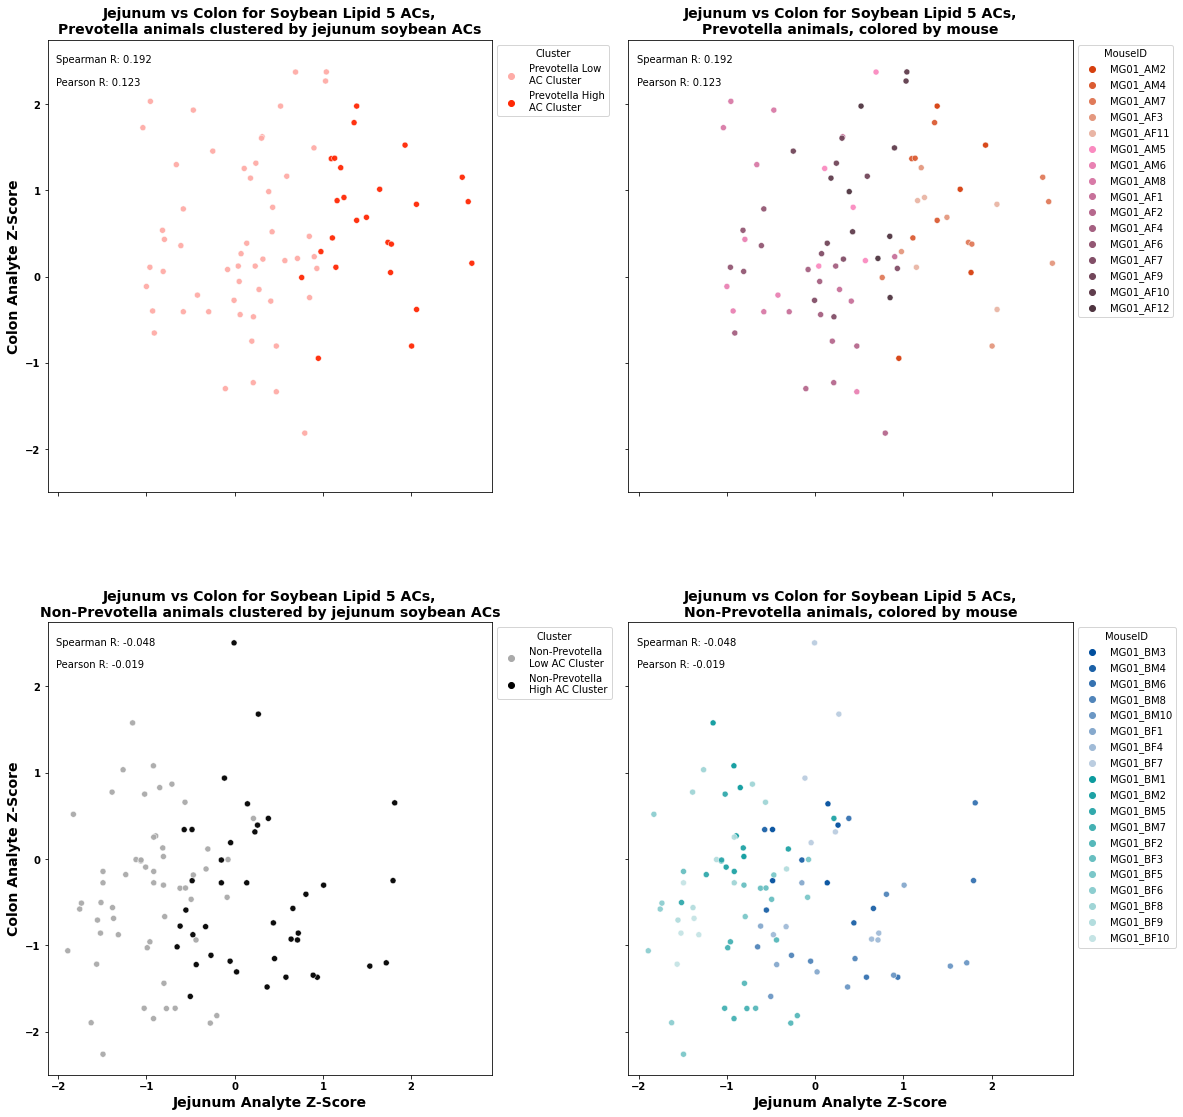

In [12]:
tissue_tag = "JejunumCluster"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean5_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC_single_ax     
overwrite=True

for tissue2 in ["Colon","Gastroc","Heart","Liver"]:
    arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])
    if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
        fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                             tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                            axes_analyte_map=analyte_axes_map,zscore=False,title_clusters_label="jejunum soybean ACs")
        plt.savefig(arm_split_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

tissue2 = "Colon"        
mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_raw_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=False,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

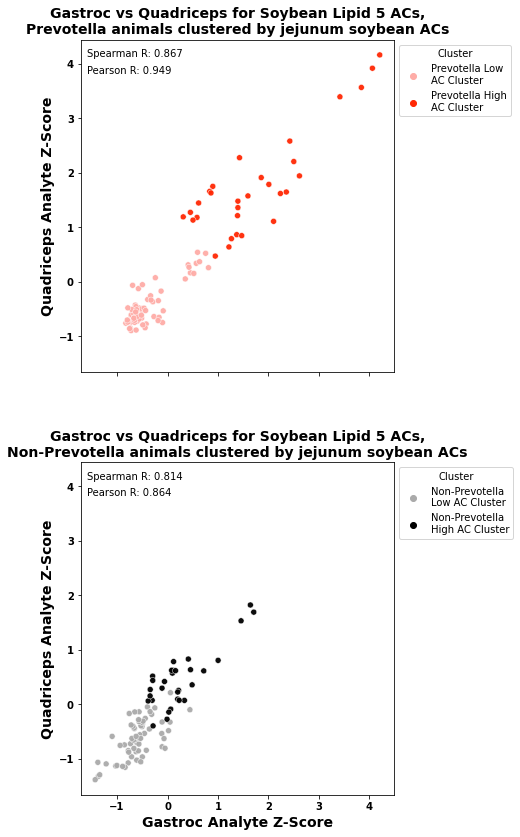

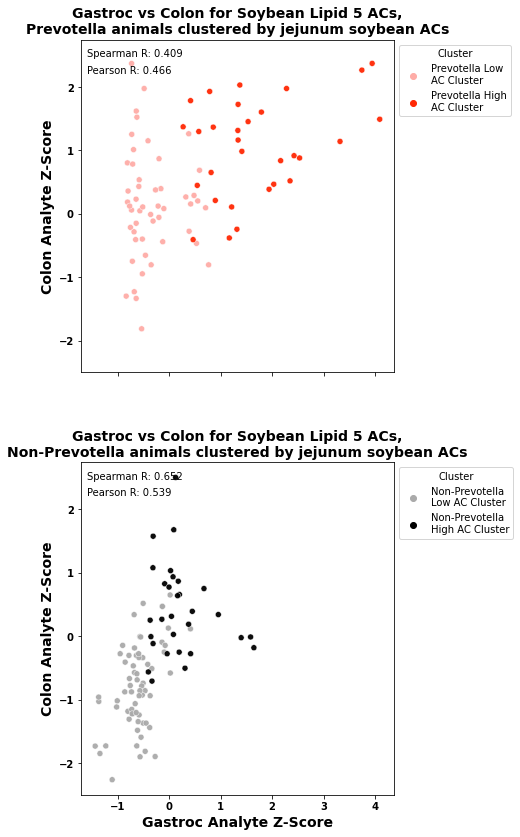

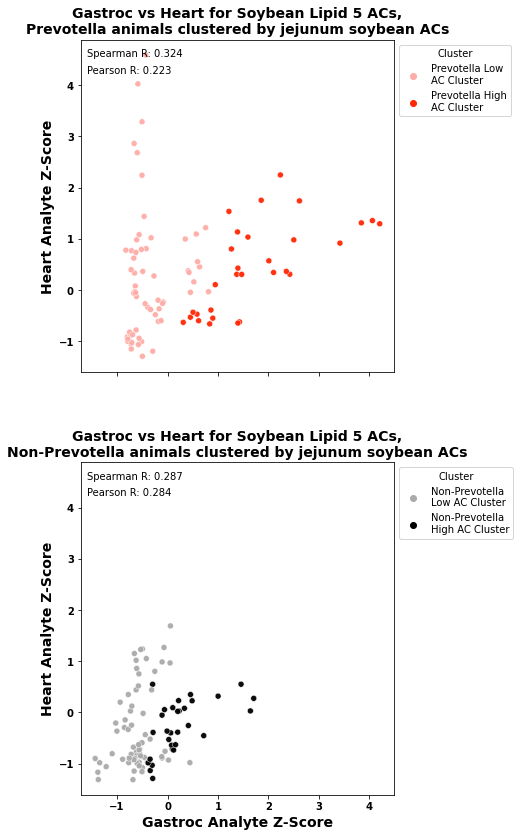

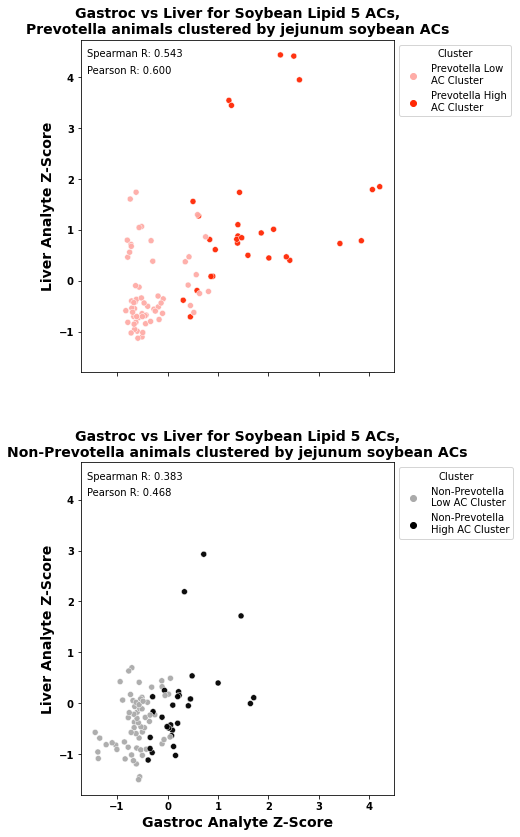

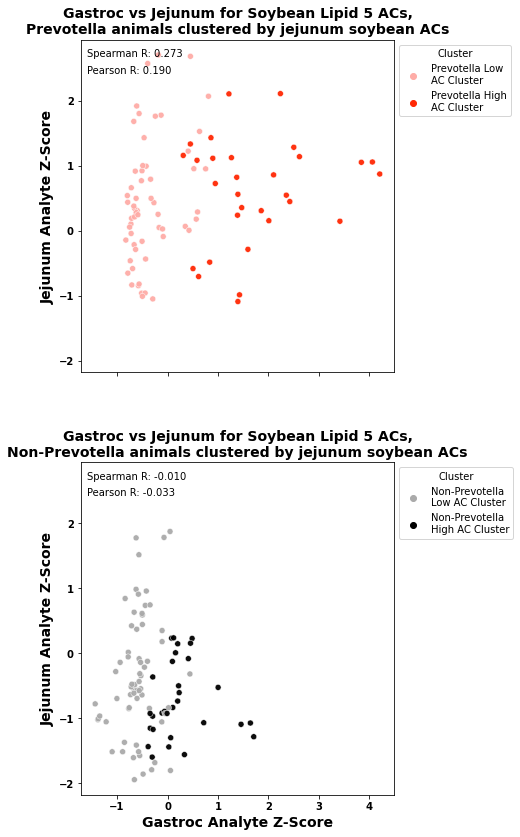

In [13]:
tissue_tag = "GastrocCluster"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Gastroc"
cluster_obs_df = soybean5_skmuscle_obs_df
analyte_axes_map = analyte_ax_map_5AC     
overwrite=True

for tissue2 in ["Quadriceps","Colon","Heart","Liver","Jejunum"]:
    arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])
    if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
        fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                             tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                            axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
        plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                    dpi=300,bbox_inches="tight",facecolor="w")

In [14]:
import nbimporter
import MS_analyte_bar as analyte_bar
import matplotlib.patches as mpatches
from importlib import reload

reload(analyte_bar)

#Ketone and glycerol single analyte 
kg_path = "{0}/20220714_plasma_KETGLYC.csv".format(csv_dir)
kg_df = pd.read_csv(kg_path,header=0)
kg_df.rename(columns={"KET":"Ketones"},inplace=True)

#NEFA data 
NEFA_path = "{0}/20220608_Lee-Chang_plasma_NEFA.csv".format(csv_dir)
NEFA_df = pd.read_csv(NEFA_path,header=0)
NEFA_df.rename(columns={"NEFA":"Non-Esterified Fatty Acids"},inplace=True)

#BW
BW_rel23_path = "{0}/BW_rel23_long.csv".format(csv_dir)
BW_rel18_path = "{0}/BW_rel18_long.csv".format(csv_dir)
BW_rel23_df = pd.read_csv(BW_rel23_path,header=0)
BW_rel23_df.loc[:,"Weight"] = BW_rel23_df.loc[:,"Weight"]*100
BW_rel23_sac_weight = BW_rel23_df.loc[BW_rel23_df["Day"]==52]
display(BW_rel23_sac_weight)
BW_rel18_df = pd.read_csv(BW_rel18_path,header=0)
BW_rel18_df.loc[:,"Weight"] = BW_rel18_df.loc[:,"Weight"]*100
BW_rel18_sac_weight = BW_rel18_df.loc[BW_rel18_df["Day"]==52]

#Cecal_SCFA 
SCFA_path = "{0}/Cecal_SCFA_data.csv".format(csv_dir)
SCFA_df = pd.read_csv(SCFA_path,header=0)
SCFA_df.rename(columns=lambda x: x.strip(),inplace=True)

soybean5_skmuscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps"])
soybean5_skmuscle_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                      tissues=["Gastroc","Quadriceps"],offset=False)
soybean5_heart_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                      tissues=["Heart"],offset=False)
soybean5_jej_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum"],offset=False)
soybean5_intestines_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                        tissues=["Jejunum","Colon"],offset=False)

HWDC_arm_cluster_palette={"A_0":"#FEACA7","A_1":"#FF2804","B_0":"#AAAAAA","B_1":"#000000"}
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}/cluster_bar".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)


def arm_cluster_analyte_bar(data_df,cluster_obs_df,analyte,tissue,sampleID_col="Mouse_ID",
                            palette=HWDC_arm_cluster_palette, units="µM",cluster_legend_label="Soybean ACs",
                           fig_fmt="pdf",figpath_cluster_tag=""):
    
    if len(cluster_obs_df) < len(data_df): #Mismatch length handling for missing data 
        data_df = data_df.loc[data_df[sampleID_col].isin(obs_df.index)]
        
    if "Tissue" in data_df.columns:
        data_df = data_df.loc[data_df["Tissue"]==tissue]
    
    #Adding in Arm/Cluster Data to data_df 
    data_df = data_df.set_index(sampleID_col)
    data_df.loc[:,"Arm"] = cluster_obs_df["Arm"]
    data_df.loc[:,"Cluster"] = cluster_obs_df["Cluster"].astype(int)
    data_df.loc[:,"Arm_Cluster"] = data_df["Arm"] + "_" + data_df["Cluster"].astype(str)
    data_df.reset_index(inplace=True)
    
    data_A, data_B = data_df[data_df["Arm"]=="A"], data_df[data_df["Arm"]=="B"]
    #Fig, ax
    fig,ax = plt.subplots(1,1,figsize=(3,6))
    #Barplot + swarmplot overlay 
    sns.barplot(data=data_df,x="Arm_Cluster",y=analyte,ax=ax,zorder=0,palette=palette.values(),
                            capsize=0.1,errwidth=1,alpha=0.7,order=palette.keys())
    sns.swarmplot(data=data_df,x="Arm_Cluster",y=analyte, ax=ax, zorder=1,palette=palette.values(),
                  dodge=True,order=palette.keys())
    #Change error bar colors to match bars 
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        newcolor = list(HWDC_cluster_palette.values())[i//lines_per_err]
        line.set_color(newcolor)

    #Significance bracket plotting
    ymin, ymax = ax.get_ylim()
    y1, y2 = ymax - (ymax-ymin)*0.01, ymax
    #Arm A Bars Significance Bracket
    stat,pval,sigstr = analyte_bar.single_analyte_stats(data_A,analyte_col=analyte,tissue=tissue,
                                                        sampleID_col=sampleID_col,split="cluster")
    analyte_bar.significance_bracket(ax,pval,sigstr,sigstr_fmt="std",x1=0,x2=1,y1=y1,y2=y2)
    #Arm B Bars Significance Bracket 
    stat,pval,sigstr = analyte_bar.single_analyte_stats(data_B,analyte_col=analyte,tissue=tissue,
                                                        sampleID_col=sampleID_col,split="cluster")
    analyte_bar.significance_bracket(ax,pval,sigstr,sigstr_fmt="std",x1=2,x2=3,y1=y1,y2=y2)

    ax.set_xlabel("Analyte KMeans Cluster".format(cluster_legend_label))
    ax.set_ylabel("{0} ({1})".format(analyte,units))
    ax.set_xticklabels(ax.get_xticklabels(),size=0)

    #Bolding of fonts 
    labels =  ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    ax.set_xlabel(ax.get_xlabel(),fontweight="bold",fontsize=14)
    ax.set_ylabel(ax.get_ylabel(),fontweight="bold",fontsize=14)

    #Custom legend entries 
    A0_patch = mpatches.Patch(color="#FEACA7", label='(+) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label))
    A1_patch = mpatches.Patch(color="#FF2804", label='(+) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label))
    B0_patch = mpatches.Patch(color="#AAAAAA", label='(—) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label))
    B1_patch = mpatches.Patch(color="#000000", label='(—) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label))
    ax.legend(handles=[A0_patch,A1_patch,B0_patch,B1_patch])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    fig_path = "{0}/{1}_{2}_{3}.{4}".format(clusters_bar_path,tissue,analyte,figpath_cluster_tag,fig_fmt)
    plt.savefig(fig_path,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)




,MouseID,Isolator,Sex,Cage,Day,Weight
54,MG01_AM1,A,M,1,52,144.5783
55,MG01_AM2,A,M,1,52,130.2353
56,MG01_AM3,A,M,1,52,137.3810
57,MG01_AM4,A,M,1,52,138.2609
58,MG01_AM5,A,M,2,52,125.5696
59,MG01_AM6,A,M,2,52,147.6923
60,MG01_AM7,A,M,2,52,167.6389
61,MG01_AM8,A,M,2,52,157.2152
62,MG01_AF1,A,F,1,52,119.8837
63,MG01_AF2,A,F,1,52,155.5263


/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


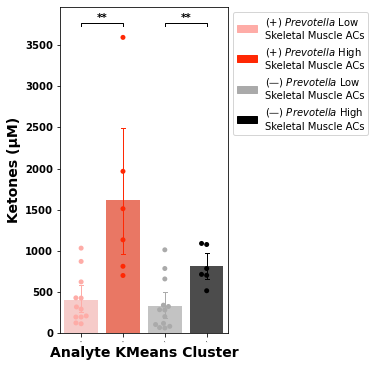

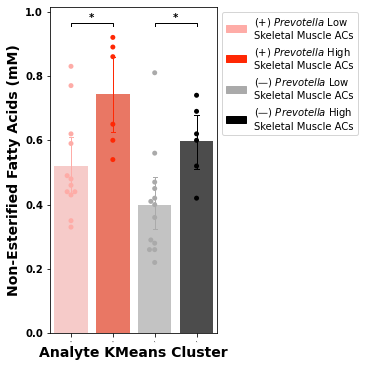

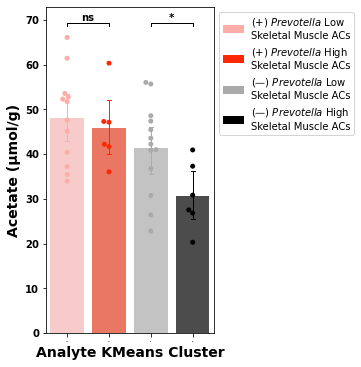

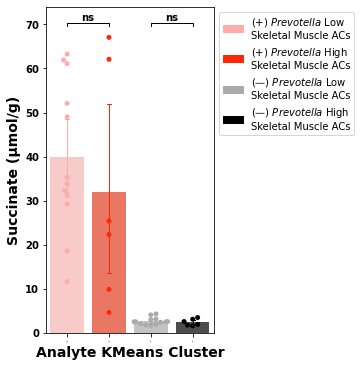

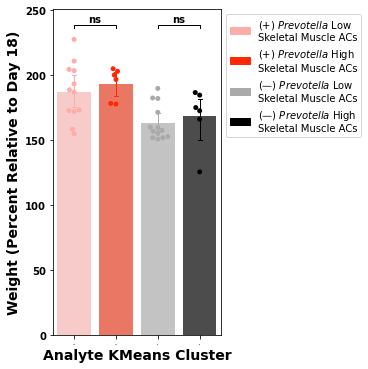

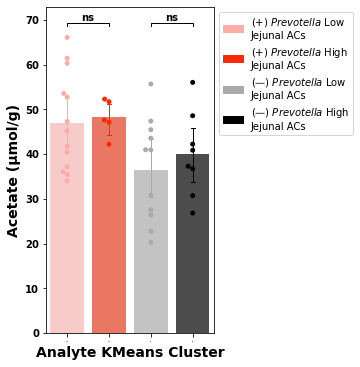

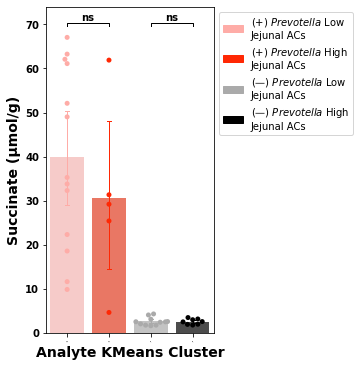

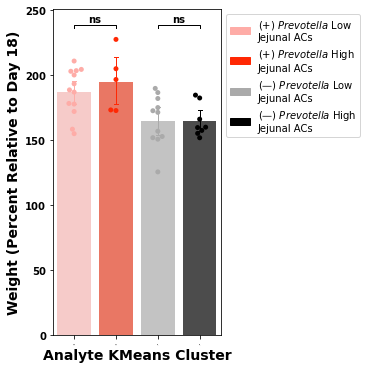

In [15]:
###Skeletal muscle AC clustering###

tissue_tag = "GQ"
clusters_bar_path = "figures/cluster_bar/{0}".format(tissue_tag)
if not os.path.exists(clusters_bar_path):
    os.makedirs(clusters_bar_path)    
    
    
obs_df = soybean5_skmuscle_unstaggered_obs
# obs_df = soybean5_heart_unstaggered_obs
cluster_legend_label = "Skeletal Muscle ACs"
figpath_cluster_tag="skm_soyACs"

analyte = "Ketones"
units = "µM"    
arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Glycerol"
# units = "mg/dL"    
# arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)
analyte = "Non-Esterified Fatty Acids"
units = "mM"
arm_cluster_analyte_bar(NEFA_df,obs_df,analyte,tissue="Plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Acetate"
units = "µmol/g"
arm_cluster_analyte_bar(SCFA_df,obs_df,analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Succinate"
units = "µmol/g"
arm_cluster_analyte_bar(SCFA_df,obs_df,analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Citrulline"
# units = "µM"    
# arm_cluster_analyte_bar(tissue_amine_df,obs_df,analyte,tissue="Jejunum",sampleID_col="SampleID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)
# analyte = "Weight"
# units = "Percent Relative to Day 23"
# arm_cluster_analyte_bar(BW_rel23_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)

analyte = "Weight"
units = "Percent Relative to Day 18"
arm_cluster_analyte_bar(BW_rel18_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

###Jejunal AC Clustering###
tissue_tag = "Jejunum"
clusters_bar_path = "figures/cluster_bar/{0}".format(tissue_tag)
if not os.path.exists(clusters_bar_path):
    os.makedirs(clusters_bar_path)    
    
    
obs_df = soybean5_jej_unstaggered_obs

cluster_legend_label = "Jejunal ACs"
figpath_cluster_tag="jej_soyACs"

# analyte = "Ketones"
# units = "µM"    
# arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Glycerol"
# units = "mg/dL"    
# arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Non-Esterified Fatty Acids"
# units = "mM"
# arm_cluster_analyte_bar(NEFA_df,obs_df,analyte,tissue="Plasma",sampleID_col="Mouse_ID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Citrulline"
# units = "µM"    
# arm_cluster_analyte_bar(tissue_amine_df,obs_df,analyte,tissue="Jejunum",sampleID_col="SampleID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)

# analyte = "Weight"
# units = "Percent Relative to Day 23"
# arm_cluster_analyte_bar(BW_rel23_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
#                         palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
#                        figpath_cluster_tag=figpath_cluster_tag)


analyte = "Acetate"
units = "µmol/g"
arm_cluster_analyte_bar(SCFA_df,obs_df,analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Succinate"
units = "µmol/g"
arm_cluster_analyte_bar(SCFA_df,obs_df,analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Weight"
units = "Percent Relative to Day 18"
arm_cluster_analyte_bar(BW_rel18_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

,SampleID,Tissue,C16,C18,C18:1,C18:2,C18:3
148,MG01_AM1,Jejunum,149.526,111.235,125.781,146.744,11.979
149,MG01_AM2,Jejunum,205.385,109.737,185.463,188.030,18.397
150,MG01_AM3,Jejunum,125.313,96.689,100.967,112.732,10.268
151,MG01_AM4,Jejunum,177.349,113.160,162.146,161.718,18.397
152,MG01_AM5,Jejunum,136.145,104.176,130.059,125.995,12.407
153,MG01_AM6,Jejunum,92.816,67.810,74.014,80.859,14.332
154,MG01_AM7,Jejunum,242.130,144.819,189.741,180.970,15.616
155,MG01_AM8,Jejunum,91.754,66.955,88.988,69.950,9.626
156,MG01_AF1,Jejunum,169.278,96.047,123.000,118.722,10.910
157,MG01_AF2,Jejunum,139.755,87.063,120.005,136.263,14.332


,MouseID,Analyte_1,Analyte_2,Cluster
0,MG01_AM1,0.432067,0.994103,0
1,MG01_AM2,1.804677,0.923573,1
2,MG01_AM3,-0.162913,0.309239,0
3,MG01_AM4,1.115755,1.084737,1
4,MG01_AM5,0.103259,0.661746,0
...,...,...,...,...
32,MG01_BF6,-1.806397,-1.795444,2
33,MG01_BF7,0.231779,0.236514,3
34,MG01_BF8,-1.301657,-1.443293,2
35,MG01_BF9,-1.599701,-1.438532,2


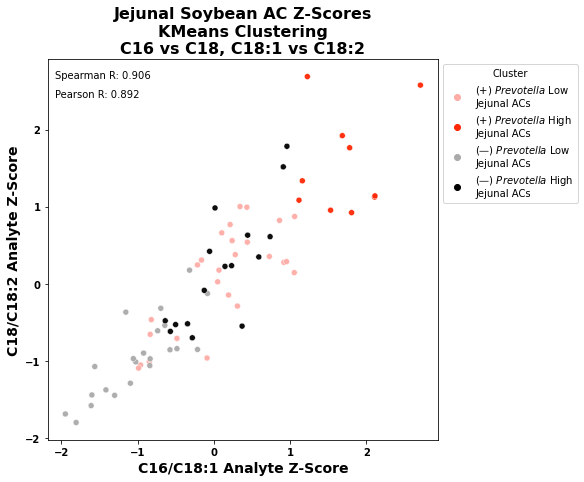

In [18]:
# display(tissue_AC_df)
jej_soybean_AC_df = tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Jejunum"][['SampleID','Tissue']+soybean_5ACs]
display(jej_soybean_AC_df)
zscore=True 
test_long_df = single_tissue_analyte_long_df(jej_soybean_AC_df,analytes=soybean_5ACs,tissue1="Jejunum",
                              obs_df=soybean5_jej_obs_df,axes_analyte_map=analyte_ax_map_5AC)
fig,ax = plt.subplots(1,1,figsize=(7,7))
cluster_legend_label = "Jejunal ACs"
cluster_labels = ['(+) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label),
                  '(+) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label),
                  '(—) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label),
                  '(—) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label)
                 ]
SFA_soybean = ["C16","C18"]
UFA_soybean = ["C18:1","C18:2"]
test_SFA_df = test_long_df[test_long_df["Analyte"].isin(SFA_soybean)] 
SFA_formatted = pd.DataFrame(index=test_long_df["MouseID"].unique(),columns=SFA_soybean)
for analyte in SFA_soybean:
    if zscore:
        SFA_formatted.loc[:,analyte] = sp_stats.zscore(test_SFA_df.loc[test_SFA_df["Analyte"]==analyte]["Jejunum"].tolist())
    else:
        SFA_formatted.loc[:,analyte] = test_SFA_df.loc[test_SFA_df["Analyte"]==analyte]["Jejunum"].tolist()
SFA_formatted.loc[:,"Cluster"] = test_SFA_df.loc[test_SFA_df["Analyte"]==analyte]["Cluster"].tolist()
SFA_formatted = SFA_formatted.reset_index().rename(columns={"index":"MouseID"})
# display(SFA_formatted)
MS_cluster_scatter(SFA_formatted,tissue1=SFA_soybean[0],tissue2=SFA_soybean[1],ax=ax)#,hue_type="cluster_mouse")
test_UFA_df = test_long_df[test_long_df["Analyte"].isin(UFA_soybean)]
UFA_formatted = pd.DataFrame(index=test_long_df["MouseID"].unique(),columns=UFA_soybean)
UFA_formatted = UFA_formatted.reset_index().rename(columns={"index":"MouseID"})
for analyte in UFA_soybean:
    if zscore:
        UFA_formatted.loc[:,analyte] = sp_stats.zscore(test_UFA_df.loc[test_UFA_df["Analyte"]==analyte]["Jejunum"].tolist())
    else:
        UFA_formatted.loc[:,analyte] = test_UFA_df.loc[test_UFA_df["Analyte"]==analyte]["Jejunum"].tolist()
UFA_formatted.loc[:,"Cluster"] = test_UFA_df.loc[test_UFA_df["Analyte"]==analyte]["Cluster"].tolist()
MS_cluster_scatter(UFA_formatted,tissue1=UFA_soybean[0],tissue2=UFA_soybean[1],ax=ax)

combined_df = pd.concat([SFA_formatted.rename(columns=dict(zip(SFA_soybean,["Analyte_1","Analyte_2"]))),
                        UFA_formatted.rename(columns=dict(zip(UFA_soybean,["Analyte_1","Analyte_2"])))])
display(combined_df)
SCC_PCC_annotation(combined_df,ax,tissue1="Analyte_1",tissue2="Analyte_2")

xlabel = "{0}/{1} Analyte Z-Score".format(SFA_soybean[0],UFA_soybean[0])
ylabel = "{0}/{1} Analyte Z-Score".format(SFA_soybean[1],UFA_soybean[1])
title = "Jejunal Soybean AC Z-Scores\nKMeans Clustering\nC16 vs C18, C18:1 vs C18:2"
standardize_plot_style(ax,xlabel,ylabel,title=title)
handles, labels = ax.get_legend_handles_labels()
n_clusters = len(test_long_df["Cluster"].unique())
ax.legend(handles[:n_clusters],cluster_labels,title="Cluster")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
fig_path = "figures/analyte_scatter/cluster/JejunumCluster/1panel_AllSampleZscore_soybean4.pdf"
plt.savefig(fig_path,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")

# MS_cluster_scatter(test_SFA_df,tissue1=)
# display(test_long_df)

,Cluster,Jej_ZS,Col_ZS,Liv_ZS,Ket_ZS,Glyc_ZS,NEFA_ZS,Citrulline_ZS
SampleID,,,,,,,,
MG01_AM1,0,0.545721,NaN,-0.847421,-0.679976,0.366387,-0.514323,-0.784628
MG01_AM2,1,1.553061,0.721634,-0.524029,-0.679945,0.505283,0.501321,0.414856
MG01_AM3,0,-0.051743,NaN,-0.985985,-0.789307,-0.369765,-0.353958,-0.059976
MG01_AM4,1,1.225648,1.123999,-0.223783,0.259242,-0.842014,0.394411,-1.156009
MG01_AM5,0,0.360072,0.946091,0.641162,0.349421,-1.189255,-0.941962,0.084905
MG01_AM6,0,-0.559534,-0.327310,1.166916,0.595502,-1.244814,-1.048872,0.903828
MG01_AM7,1,1.923984,0.555691,-0.571095,-0.804678,-0.439214,-0.460868,0.429493
MG01_AM8,0,-0.770353,1.314740,1.250305,2.017701,-1.633724,0.073681,-0.298136
MG01_AF1,0,0.313465,0.201113,-0.425774,-0.533651,1.116428,0.340956,-0.190964


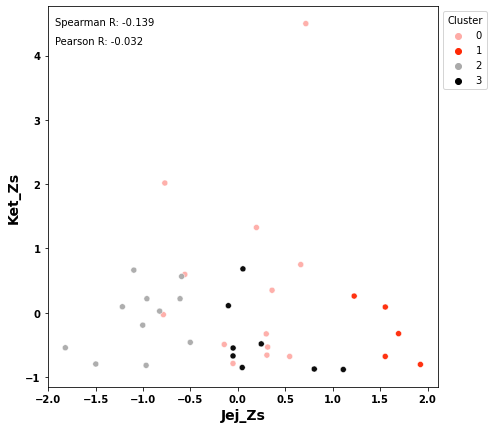

In [168]:
#Checking analyte zscore correlation 
#TODO: add in raw (non-zscore) transformed data
soy_analytes = soybean_5ACs
jej_soybean_AC_df = tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Jejunum"][['SampleID','Tissue']+soy_analytes]
colon_soybean_AC_df = tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Colon"][['SampleID','Tissue']+soy_analytes]
liver_soybean_AC_df = tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Liver"][['SampleID','Tissue']+soy_analytes]
liver_soybean_zs_df = liver_soybean_AC_df.copy()
colon_soybean_zs_df = colon_soybean_AC_df.copy()
jej_soybean_zs_df = jej_soybean_AC_df.copy()

amine_analytes = ["Citrulline","Glutamine","Glutamic Acid"]
jej_amine_df = pd.DataFrame(tissue_amine_df.loc[tissue_amine_df["Tissue"]=="Jejunum",amine_analytes])
for amine_analyte in amine_analytes:
    jej_amine_df.loc[:,"{0}_ZS".format(amine_analyte)] = sp_stats.zscore(jej_amine_df[amine_analyte])

for analyte in soy_analytes:
    jej_soybean_zs_df.loc[:,analyte] = sp_stats.zscore(jej_soybean_zs_df.loc[:,analyte])
    colon_soybean_zs_df.loc[:,analyte] = sp_stats.zscore(colon_soybean_zs_df.loc[:,analyte])
    liver_soybean_zs_df.loc[:,analyte] = sp_stats.zscore(liver_soybean_zs_df.loc[:,analyte])

jej_soybean_zs_df.loc[:,"avg_zs"] = jej_soybean_zs_df.loc[:,soy_analytes].mean(axis=1)
colon_soybean_zs_df.loc[:,"avg_zs"] = colon_soybean_zs_df.loc[:,soy_analytes].mean(axis=1)
liver_soybean_zs_df.loc[:,"avg_zs"] = liver_soybean_zs_df.loc[:,soy_analytes].mean(axis=1)
jej_soybean_zs_df.loc[:,"Cluster"] = soybean5_jej_obs_df["Cluster"].tolist()
colon_soybean_zs_df.loc[:,"Cluster"] = soybean5_jej_obs_df[soybean5_jej_obs_df.index.isin(colon_soybean_zs_df["SampleID"])]["Cluster"].tolist()
#corr_df 
corr_columns = ["Cluster"]
corr_df = pd.DataFrame(index=jej_soybean_zs_df["SampleID"],columns=corr_columns)
corr_df.loc[:,"Cluster"] = soybean5_jej_obs_df.loc[:,"Cluster"]
corr_df.loc[:,"Jej_ZS"] = jej_soybean_zs_df.loc[:,"avg_zs"].tolist()
corr_df.loc[colon_soybean_zs_df["SampleID"],"Col_ZS"] = colon_soybean_zs_df.loc[colon_soybean_zs_df["SampleID"].isin(min_idx),"avg_zs"].tolist()
corr_df.loc[:,"Liv_ZS"] = liver_soybean_zs_df.loc[:,"avg_zs"].tolist()

corr_df.loc[:,"Ket_ZS"] = sp_stats.zscore(kg_df.loc[:,"Ketones"]).tolist()
corr_df.loc[:,"Glyc_ZS"] = sp_stats.zscore(kg_df.loc[:,"Glycerol"]).tolist()
corr_df.loc[:,"NEFA_ZS"] = sp_stats.zscore(NEFA_df.loc[:,"Non-Esterified Fatty Acids"]).tolist()
corr_df.loc[:,"Citrulline_ZS"] = jej_amine_df["Citrulline_ZS"].tolist()

display(corr_df)

fig,ax = plt.subplots(1,1,figsize=(7,7))
col1, col2 = "Jej_ZS","Ket_ZS"
# col1, col2 = "Glutamine_ZS","Glutamic Acid_ZS"
MS_cluster_scatter(corr_df,col1,col2,ax,hue_type="cluster")
#Determine if na filtering is needed before SCC/PCC annotation 

scc_df = corr_df.loc[:,[col1,col2]]
if scc_df.isna().any(axis=0).sum() > 0:
    scc_df = scc_df.loc[~scc_df.isna().any(axis=1)]
SCC_PCC_annotation(scc_df,ax,col1,col2)

    